<a href="https://colab.research.google.com/github/hoangdungnguyen/XVA-stage/blob/master/Hyperparameter_tuning_VaR_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 185 (delta 5), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (185/185), 57.14 KiB | 14.28 MiB/s, done.
Resolving deltas: 100% (67/67), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rap

In [2]:
import cuml

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist

#from kmeans_pytorch import kmeans

print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available:  True


In [5]:
### Model parameters
dim_X = 40

N_sim = 20000

eps = 0.025

### Hyper parameters 
Kfold = 3
max_epochs = 300

learning_rate = hp.choice('learning_rate',[0.001,0.01,0.1,0.5,1])
batchsize = hp.choice('batchsize',[1000, 5000, N_sim])
unit_num = hp.choice('unit_num',[40,100,200,400])
hlayer_num = hp.choice('layer_num',[1,2])
regularization_weight = hp.choice('regularization_weight',[0,0.1,0.5,1])
activation = hp.choice('activation', [F.relu, F.sigmoid, F.softplus, F.elu])

space_NN = {
    'learning_rate': learning_rate,
    'batch_size': batchsize,
    'unit_num': unit_num,
    'hlayer_num': hlayer_num,
    'regularization_weight': regularization_weight,
    'activation': activation
}

space_ELM = {
    'unit_num': hp.choice('unit_num',[100,200,400,600]),
    'projection': hp.choice('projection', ['Gauss', 'Rademacher', 'Achlioptas']),
    'regularization_weight': regularization_weight,
    'activation': activation
}

space_RBF = {
    'unit_num': hp.choice('unit_num',[40,100,200,20]),
    'regularization_weight': regularization_weight,
    'activation': hp.choice('activation', ['Gaussian', 'Multiquadric', 'Inverse quadratic', 'Thin plate spline']),
    'shape_para': hp.choice('shape_para',[.1,0.5,1,2,5,10])
}

rs = 1828

# 1 Data simulator

In [57]:
class var_es_generator:

    def __init__(self, X_dim = dim_X, eps = 0.025, lambda_rs = 10, mu_rs = 20):
        self.X_dim = X_dim
        self.eps = eps
        self.lambda_rs = lambda_rs
        self.mu_rs = mu_rs
        
    
    def mean_X(self):
        return np.zeros(self.X_dim)
    
    def var_X(self):
        A = np.random.randn(self.X_dim,self.X_dim)
        A = np.matmul(A.T,A)
        A /= A.max()
        np.fill_diagonal(A,1)
        return np.identity(self.X_dim)
        #return A

    def cond_mean_std_Y(self, X, weight_vector): 
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * weight_vector, axis = 1)
    
    def simulate(self, nb_simulation = N_sim, 
                 lambda_0 = 0., 
                 mu_0 = 0.) :
                 
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), nb_simulation)
        #lambda vector : P1(x) = lambda_0 + sum lambda_i*xi + sum lambda_ij*xi*xj
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(self.lambda_rs).uniform(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))
        #self.lambda_vector = np.append(lambda_0, np.random.RandomState(self.lambda_rs).rand(int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))
        #mu vector : P2(x) = mu_0 + sum mu_i*xi + sum mu_ij*xi*xj
        self.mu_vector = np.append(mu_0, np.random.RandomState(self.mu_rs).uniform(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))
        #self.mu_vector = np.append(mu_0, np.random.RandomState(self.mu_rs).rand(int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        mean_Y = self.cond_mean_std_Y(X, self.lambda_vector)
        std_Y = self.cond_mean_std_Y(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(nb_simulation, self.X_dim)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)

#2 Randomized layers

In [7]:
class Rademacher_dist:
    def sample(dim):
        return 2*tdist.bernoulli.Bernoulli(0.5).sample(dim)-1
class Achlioptas_dist:
    def sample(dim):
        return (tdist.categorical.Categorical(probs=torch.tensor([1/6,2/3,1/6])).sample(dim) -1)*np.sqrt(3)

class Gauss_normalized:
    def sample(dim):
        if len(dim) == 2:
            return tdist.normal.Normal(0., 1.).sample(dim)/dim[1]
        else:          
            return tdist.normal.Normal(0., 1.).sample(dim)/dim[0]

class Randomprojection:

    def __init__(self, Layers = [10, 100], random_state = None, bias = True, activation = F.relu, projection = 'Gauss'):
        if projection == 'Gauss':
            dist = tdist.normal.Normal(0., 1.)
        elif projection == 'Rademacher':
            dist = Rademacher_dist
        elif projection == 'Achlioptas':
            dist = Achlioptas_dist
        elif projection == 'Gauss_normalized':
            dist = Gauss_normalized

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    torch.manual_seed(2*random_state+i)
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        self.activation = activation
        self.bias = bias
    def fit_transform(self, X):
        X = X.to(device)
        if self.bias:
            for W,b in zip(self.W, self.b):
                X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        else :
            for W in self.W:
                X = self.activation(torch.matmul(X, W.to(device)))
        return X

In [8]:
class Autoencoder(nn.Module):

    def __init__(self, Layers = [1,20,40], activation = F.relu):
        super(Autoencoder, self).__init__()
        self.hidden = nn.ModuleList()
        # Example: Encoder 1 - 20 - 40 and Decoder 40 - 20 - 1
        Layers = Layers + Layers[::-1]
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

    def forward_central_layer(self, x):
        x = x.to(device)
        L = int(len(self.hidden) / 2)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [9]:
from cuml.cluster import KMeans

class RBFlayer:
    """RBFlayer.
    Parameters
    ----------
    function: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.float)


    def fit(self, X):
        kmeans = KMeans(n_clusters=self.K, max_iter=10, oversampling_factor=1, output_type='numpy')
        kmeans.fit(X_train.to(device))
        self.centroids = torch.Tensor(kmeans.cluster_centers_).type(torch.float)
          
    def transform(self, X):
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)

#3 Readout layers

In [10]:
from sklearn.linear_model import LinearRegression, Ridge

class LR_readout:
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = LinearRegression(fit_intercept=intercept, normalize=normalize, n_jobs=-1)
        else:
            self.lin_reg = Ridge(alpha = regularization_weight, solver = 'cholesky',
                                 fit_intercept=intercept, normalize=normalize)

    def fit(self, X, y):
        self.lin_reg.fit(X.cpu(),y.cpu())
        self.coef = torch.tensor(self.lin_reg.coef_.T)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X.cpu())).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        return torch.mean((self.predict(X)*weight - y)**2)

In [11]:
class LR_readout_cuml:
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = cuml.LinearRegression(fit_intercept=intercept, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.lin_reg = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=intercept, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        self.lin_reg.fit(X,y)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X)).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        return torch.mean((self.predict(X).reshape(y.shape)*weight - y)**2)

In [12]:
class NN_nlayers(nn.Module):

    def __init__(self, Layers, activation = F.relu):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [13]:
def train_quad_loss_optimal(model, X_train, y_train, eps = 1e-8, epochs=5, verbose = None):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    A,b = model.parameters()
    i = 0
    err, best_err = np.inf, np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best')
        loss.backward()
        coef = torch.matmul(X_train, A.grad.T)+ b.grad
        lr = torch.matmul(coef.T, torch.matmul(X_train, A.data.T)+ b.data - y_train)/ torch.matmul(coef.T,coef)
        for param_group in optimizer.param_groups:
            param_group['lr'] = float(lr)
        
        
        optimizer.step()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {} | learning rate = {}'.format(i, round(err, 3), round(float(lr),4)))
        i += 1
    model.load_state_dict(torch.load('best'))
    model.eval()
    

In [14]:
class IRLS_quantile_regression:
    
    def __init__(self, intercept = True, normalize=False, eps = eps, regularization_weight = 0, v = 1e-4,
                 verbose = None, max_inter = 10):
        self.intercept = intercept
        self.verbose = verbose
        self.v = v
        self.eps = eps
        self.max_iter = max_inter

        if regularization_weight == 0:
            self.regressor = cuml.LinearRegression(fit_intercept=False, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.regressor = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=False, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        
        if self.intercept:
            Xm = torch.cat([torch.ones(X.shape[0],1).to(device), X], dim =1)
        else:
            Xm = X
        
        one = np.ones(Xm.shape[0])
        mult = one.copy()
        W = one.copy() 
        last_resi = None
        for i in range(0, self.max_iter): 
            weight = torch.sqrt(torch.from_numpy(W)).view(-1,1).type(torch.FloatTensor).to(device)
            self.regressor.fit(weight*Xm,weight*y)
            
            residual = y.cpu().numpy().ravel() - self.regressor.predict(Xm)
            sign = np.sign(residual)
            residual = np.abs(residual)
            mult[sign > 0] = self.eps
            mult[sign <0] = 1-self.eps

            W = np.reciprocal(np.maximum(residual, one*self.v))
            residual *= 1 - mult
            W *= 1-mult

            l1_resi = residual.sum()

            if self.verbose:
                print(
                    'iter={0} | error={1}'.format(i + 1, E))
                
            if last_resi is not None and abs(last_resi - l1_resi) < 1e-3:
                break
            last_resi = l1_resi

      

    def predict(self, X) :
        if self.intercept:
            Xm = torch.cat([torch.ones(X.shape[0],1).to(device), X], dim =1)
        else:
            Xm = X

        return torch.from_numpy(self.regressor.predict(Xm)).type(torch.FloatTensor).reshape(-1,1).to(device)

    def l2_loss(self,X, y, weight = 1):
        return torch.mean((self.predict(X).reshape(y.shape)*weight - y)**2)

In [15]:
Data_Generator = var_es_generator()

X_train, Y_train, true_VaR_train, true_ES_train, _,_ = Data_Generator.simulate()
X_test, Y_test, true_VaR_test, true_ES_test, _,_ = Data_Generator.simulate()

# 4 Neural networks

In [ ]:
def train_var_RUbased(model_var, train_loader, learning_rate, regularization_weight,
                    epochs=max_epochs, stop_eps = 1e-8, verbose = None) :

    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    best_err =  np.inf
    
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch,y_batch = X_batch.to(device), y_batch.to(device)
            optimizer_var.zero_grad()
            q = model_var(X_batch)
            loss_var = torch.mean( 1/eps*torch.relu(y_batch - q) + q )
            loss_var.backward()
            optimizer_var.step()
            total_loss += loss_var.data.item()
        if total_loss < best_err:
            best_err = total_loss
            torch.save(model_var.state_dict(), 'best')

    model_var.load_state_dict(torch.load('best'))
    model_var.eval()


In [ ]:
def score_func(model, x_val, y_val):
    return - qloss(model(x_val), y_val)

def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_mean = 0
    for tr_idx, val_idx in kf.split(X_train):
        
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train[tr_idx, :], Y_train[tr_idx,:]),
            batch_size = params['batch_size'], shuffle = True)      
        
        var_NN = NN_nlayers(Layers=[dim_X]+[params['unit_num']]*params['hlayer_num']+[1], 
                            activation = params['activation']).to(device)
        train_var_RUbased(var_NN, train_loader, params['learning_rate'], params['regularization_weight'])

        X_val, y_val = X_train[val_idx, :].to(device), Y_train[val_idx,:].to(device)
        score = score_func(var_NN, X_val, y_val)

        score_mean += score
        print(f' CV {count} - score: {round(-score, 4)}')
        count += 1
        del train_loader, X_val,y_val, var_NN
        torch.cuda.empty_cache()
        gc.collect()
        
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,0)}")
    
    print(f'Mean score: {-score_mean / Kfold}')
    
    return -(score_mean / Kfold)

In [ ]:
%%time
# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_NN,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_NN = space_eval(space_NN, best)



############## New Run ################
params = {'activation': <function elu at 0x7f0c07c959d8>, 'batch_size': 1000, 'hlayer_num': 1, 'learning_rate': 0.01, 'regularization_weight': 0, 'unit_num': 100}
  0%|          | 0/30 [00:09<?, ?it/s, best loss: ?]


KeyboardInterrupt: ignored

In [ ]:
best_params_NN

# 5 ELM

In [ ]:

def score_func(pred, y_val):
    return - qloss(pred, y_val)

def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_mean = 0

    LR_quantile = IRLS_quantile_regression(regularization_weight= params['regularization_weight'])

    Randomprojection_layer = Randomprojection(Layers =[dim_X]+[params['unit_num']],
                                              activation = params['activation'],
                                              projection = params['projection'])
    for tr_idx, val_idx in kf.split(X_train):
        X_tr_transfomed = Randomprojection_layer.fit_transform(X_train[tr_idx, :])
        X_val_transfomed = Randomprojection_layer.fit_transform(X_train[val_idx, :])
        LR_quantile.fit(X_tr_transfomed,Y_train[tr_idx,:])
        
        score = score_func(LR_quantile.predict(X_val_transfomed), Y_train[val_idx,:])

        score_mean += score
        print(f' CV {count} - score: {round(-score, 4)}')
        count += 1
        del X_tr_transfomed, X_val_transfomed
        torch.cuda.empty_cache()
        gc.collect()
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {-score_mean / Kfold}')
    
    del Randomprojection_layer,LR_quantile
    torch.cuda.empty_cache()
    gc.collect()
    return -(score_mean / Kfold)

In [ ]:
%%time

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_ELM,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_ELM = space_eval(space_ELM, best)



############## New Run ################
params = {'activation': <function relu at 0x7f4c0e23ea60>, 'projection': 'Achlioptas', 'regularization_weight': 0.5, 'unit_num': 400}
 CV 1 - score: 2.6954
 CV 2 - score: 2.965
 CV 3 - score: 2.9357
Total Time Run: 1.3089
Mean score: 2.8653461933135986

############## New Run ################
params = {'activation': <built-in function softplus>, 'projection': 'Rademacher', 'regularization_weight': 0, 'unit_num': 600}
 CV 1 - score: 2.5971
 CV 2 - score: 2.8121
 CV 3 - score: 2.9325
Total Time Run: 1.5727
Mean score: 2.780559539794922

############## New Run ################
params = {'activation': <function relu at 0x7f4c0e23ea60>, 'projection': 'Rademacher', 'regularization_weight': 0.5, 'unit_num': 200}
 CV 1 - score: 2.9854
 CV 2 - score: 3.2355
 CV 3 - score: 3.4769
Total Time Run: 0.7815
Mean score: 3.232615868250529

############## New Run ################
params = {'activation': <built-in function softplus>, 'projection': 'Achlioptas', 'r

In [ ]:
best_params_ELM

{'activation': <function torch.nn.functional.elu>,
 'projection': 'Rademacher',
 'regularization_weight': 0,
 'unit_num': 600}

# 6 RBF networks

In [ ]:
def score_func(pred, y_val):
    return - qloss(pred, y_val)

def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_mean = 0

    LR_quantile = IRLS_quantile_regression(intercept = False,regularization_weight= params['regularization_weight'])

    RBF_hlayer = RBFlayer(output_layer=params['unit_num'], e = params['shape_para'], function = params['activation'])

    for tr_idx, val_idx in kf.split(X_train):
        RBF_hlayer.fit(X_train[tr_idx, :])

        X_tr_transfomed = RBF_hlayer.transform(X_train[tr_idx, :]).to(device)
        X_val_transfomed = RBF_hlayer.transform(X_train[val_idx, :]).to(device)

        LR_quantile.fit(X_tr_transfomed, Y_train[tr_idx,:])
        
        score = score_func(LR_quantile.predict(X_val_transfomed), Y_train[val_idx,:])

        score_mean += score
        print(f' CV {count} - score: {round(-score, 4)}')
        count += 1
        del X_tr_transfomed, X_val_transfomed
        torch.cuda.empty_cache()
        gc.collect()
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {-score_mean / Kfold}')
    
    del RBF_hlayer,LR_quantile
    torch.cuda.empty_cache()
    gc.collect()
    return -(score_mean / Kfold)

In [ ]:
%%time

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_RBF,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_RBF = space_eval(space_RBF, best)



############## New Run ################
params = {'activation': 'Inverse quadratic', 'regularization_weight': 0.5, 'shape_para': 5, 'unit_num': 200}
 CV 1 - score: 9.1543
 CV 2 - score: 9.1894
 CV 3 - score: 9.3839
Total Time Run: 4.7155
Mean score: 9.242557525634766

############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 0.1, 'shape_para': 1, 'unit_num': 20}
 CV 1 - score: 4.3484
 CV 2 - score: 4.7605
 CV 3 - score: 4.5585
Total Time Run: 0.6101
Mean score: 4.555797100067139

############## New Run ################
params = {'activation': 'Multiquadric', 'regularization_weight': 0.1, 'shape_para': 2, 'unit_num': 40}
 CV 1 - score: 3.7245
 CV 2 - score: 3.9084
 CV 3 - score: 3.9758
Total Time Run: 0.7525
Mean score: 3.8695968786875405

############## New Run ################
params = {'activation': 'Multiquadric', 'regularization_weight': 0, 'shape_para': 2, 'unit_num': 200}
 CV 1 - score: 69.4028
 CV 2 - score: 19.3891
 CV 3 - sc

In [ ]:
best_params_RBF

{'activation': 'Thin plate spline',
 'regularization_weight': 0,
 'shape_para': 0.1,
 'unit_num': 100}

## RBF ES

In [ ]:
def score_func(solution, x_val, y_val):
    return - solution.l2_loss(x_val, y_val).item()


def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_mean = 0

    LR_solution = LR_readout_cuml(intercept = False,regularization_weight= params['regularization_weight'])

    RBF_hlayer = RBFlayer(output_layer=params['unit_num'], e = params['shape_para'], function = params['activation'])
                                                  
    for tr_idx, val_idx in kf.split(X_train):
        RBF_hlayer.fit(X_train[tr_idx, :])
        X_batch = RBF_hlayer.transform(X_train[tr_idx, :]).to(device)
        X_val = RBF_hlayer.transform(X_train[val_idx, :]).to(device)
        
        LR_solution.fit(X_batch,Y_train_es[tr_idx,:])
        
        score = score_func(LR_solution, X_val, Y_train_es[val_idx, :])

        score_mean += score
        print(f' CV {count} - score: {round(-score, 4)}')
        count += 1
        del X_val, X_batch
        torch.cuda.empty_cache()
        gc.collect()
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {-score_mean / Kfold}')
    
    del RBF_hlayer, LR_solution
    torch.cuda.empty_cache()
    gc.collect()
    return -(score_mean / Kfold)

In [ ]:
%%time
space_RBF = {
    'unit_num': hp.choice('unit_num',[40,100,200,400,600]),
    'regularization_weight': regularization_weight,
    'activation': hp.choice('activation', ['Gaussian', 'Multiquadric', 'Inverse quadratic', 'Thin plate spline']),
    'shape_para': hp.choice('shape_para',[.1,0.5,1,2,5,10])
}

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_RBF,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_RBF = space_eval(space_RBF, best)



############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 0.5, 'shape_para': 0.5, 'unit_num': 40}
 CV 1 - score: 4055.4666
 CV 2 - score: 3634.8906
 CV 3 - score: 2623.4426
Total Time Run: 0.8691
Mean score: 3437.9332682291665

############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 0, 'shape_para': 10, 'unit_num': 100}
 CV 1 - score: 3966.6848
 CV 2 - score: 3585.387
 CV 3 - score: 2559.7539
Total Time Run: 1.0341
Mean score: 3370.6085611979165

############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 0, 'shape_para': 1, 'unit_num': 100}
 CV 1 - score: 3966.6848
 CV 2 - score: 3585.387
 CV 3 - score: 2559.7876
Total Time Run: 0.8979
Mean score: 3370.6197916666665

############## New Run ################
params = {'activation': 'Multiquadric', 'regularization_weight': 1, 'shape_para': 1, 'unit_num': 100}
 CV 1 - score: 3970.4353

In [ ]:
best_params_RBF

{'activation': 'Thin plate spline',
 'regularization_weight': 0.5,
 'shape_para': 10,
 'unit_num': 400}

# 7 VaR

In [47]:
sys_variables = sys.modules[__name__]

def data_simulator(dim_X = 40, nb_path = 20000, rs =None):
    try:
        del sys_variables.X_train, sys_variables.Y_train, sys_variables.true_VaR_train, sys_variables.true_ES_train
        del sys_variables.X_test, sys_variables.Y_test, sys_variables.true_VaR_test, sys_variables.true_ES_test
        torch.cuda.empty_cache()
    except:
        pass
    if rs == None:
        sys_variables.rs = random.randint(0,2000)
        rs = sys_variables.rs
    #lambda_0,mu_0 = np.random.normal(), np.random.normal()
    #Var_Es_Generator = var_es_generator(X_dim=dim_X, eps = eps, lambda_rs = rs, mu_rs= rs+1)
    #lambda_0,mu_0 = float(np.random.RandomState(rs).uniform(-1,1,1)), float(np.random.RandomState(rs).uniform(-1,1,1))
    
    Var_Es_Generator = var_es_generator(X_dim=dim_X, eps = eps, lambda_rs = rs, mu_rs= rs+1)

    X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Var_Es_Generator.simulate(nb_path, 
                                                                                                           lambda_0 = 0, 
                                                                                                           mu_0 = 0)
    X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Var_Es_Generator.simulate(nb_path, lambda_0 = 0, mu_0 = 0)

    sys_variables.X_train = X_train.to(device)
    sys_variables.Y_train = Y_train.to(device)
    sys_variables.true_VaR_train = true_VaR_train.to(device)
    sys_variables.true_ES_train = true_ES_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.Y_test = Y_test.to(device)
    sys_variables.true_VaR_test = true_VaR_test.to(device)
    sys_variables.true_ES_test = true_ES_test.to(device)

    sys_variables.eps = eps
    sys_variables.dim_X = dim_X

In [17]:
def NRMSE(pred, true):
    pred = pred.cpu().reshape(true.shape)
    true = true.cpu()
    return float(torch.sqrt(torch.mean((pred - true)**2))/ torch.std(true))

def RMSE(pred, true):
    pred = pred.cpu().reshape(true.shape)
    true = true.cpu()
    return float(torch.sqrt(torch.mean((pred - true)**2)))

def qloss(pred, y):
    u = y.reshape(pred.shape).cpu() - pred.cpu()
    return float(torch.mean((u)*(1- eps - (u<0)*1)))

def q_proba(pred, y):
    pred = pred.cpu().reshape(y.shape)
    y = y.cpu()
    return float(sum(y >pred))/len(y)

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre.data, var_train_true.data))
    
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre.data, var_test_true.data))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre.data, es_train_true.data))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre.data, es_test_true.data))

    print('RMSE in-sample VaR: ',RMSE(var_train_pre.data, var_train_true.data))
    print('RMSE out-sample VaR: ',RMSE(var_test_pre.data, var_test_true.data))

    print('Quantile loss in-sample: ', qloss(var_train_pre.data, Y_train))
    print('Quantile loss out-sample: ', qloss(var_test_pre.data, Y_test))

    print('Quantile proba in-sample: ', q_proba(var_train_pre.data, Y_train))
    print('Quantile proba out-sample: ', q_proba(var_test_pre.data, Y_test))

In [18]:
def train_var_RUbased_v2(model_var, X_train_var, y_train, eps = eps, regularization_weight = 0.,
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.001) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        q = model_var(X_train_var)
        loss_var = torch.mean( 1/eps*torch.relu(y_train - q) + q )
  
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        #err = loss_var.data.item()*X_train.shape[0]
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

In [19]:
def train_var_huberloss(model_var, X_train_var, y_train, eps = eps, regularization_weight = 0.,
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.001) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr, weight_decay=regularization_weight)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    ep = 2**-8
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        u = y_train - model_var(X_train_var)
        hu = u**2/(2*ep)*(torch.abs(u)<=ep) + (torch.abs(u) - ep/2)*(torch.abs(u)>ep)
        loss_var = torch.mean((1-eps)*hu*(u>=zero_vector) + eps*hu*(u<zero_vector))
  
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        #err = loss_var.data.item()*X_train.shape[0]
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
        if i % 10 ==0:
            ep *= 2**(-4)
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

In [58]:
data_simulator(dim_X, N_sim)

## NN

In [59]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,200,1], activation =F.elu).to(device)

train_var_RUbased_v2(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)

===Train VaR process===
[iter 0] err = 925.803
[iter 100] err = 61.042
[iter 200] err = 56.619
[iter 300] err = 55.188
[iter 400] err = 55.544
[iter 500] err = 62.539
Best error = 51.750511169433594
CPU times: user 710 ms, sys: 75.2 ms, total: 785 ms
Wall time: 803 ms


NRMSE in-sample VaR:  0.39875921607017517
NRMSE out-sample VaR:  0.41294869780540466
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  18.404010772705078
RMSE out-sample VaR:  19.11583709716797
Quantile loss in-sample:  0.7959017157554626
Quantile loss out-sample:  1.8536511659622192
Quantile proba in-sample:  0.06255
Quantile proba out-sample:  0.11575


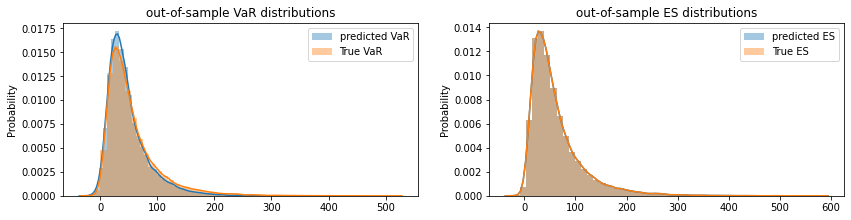

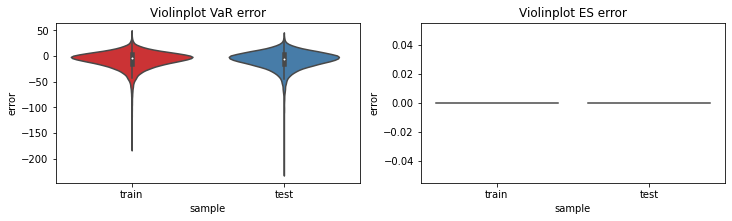

In [60]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

In [61]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_var_huberloss(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)

===Train VaR process===
[iter 0] err = 22.596
[iter 100] err = 0.99
[iter 200] err = 0.916
[iter 261] err = nan
Best error = 0.7843518257141113
CPU times: user 605 ms, sys: 114 ms, total: 719 ms
Wall time: 732 ms


NRMSE in-sample VaR:  0.3838900625705719
NRMSE out-sample VaR:  0.3950500786304474
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  17.717750549316406
RMSE out-sample VaR:  18.287290573120117
Quantile loss in-sample:  0.8097359538078308
Quantile loss out-sample:  1.7052562236785889
Quantile proba in-sample:  0.04565
Quantile proba out-sample:  0.0997


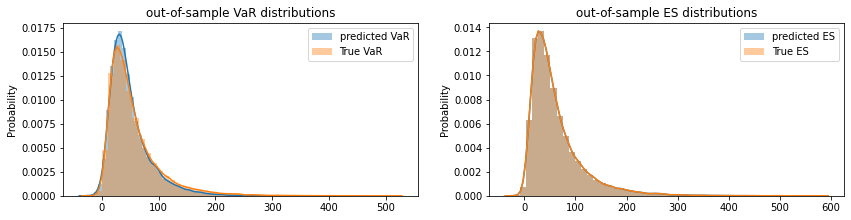

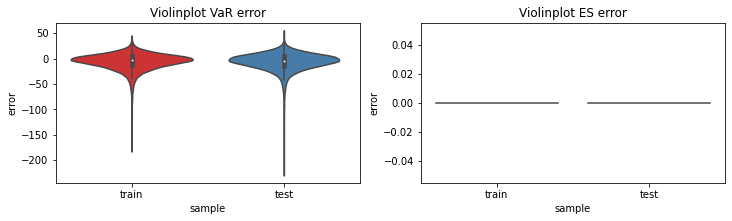

In [62]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
Qloss_NN_list

[2.046039342880249,
 1.794726014137268,
 2.061288595199585,
 2.214174509048462,
 1.9460607767105103,
 2.01511549949646]

## ELM

In [ ]:
%%time
K = 1200
RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu, 
                            projection = 'Gauss')
# ['Gauss', 'Rademacher', 'Achlioptas', Gauss_normalized]
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)
       
var_NN = NN_nlayers(Layers=[K,1], activation = torch.nn.Identity).to(device)

train_var_RUbased_v2(var_NN, X_train_var= X_train_transfomed,y_train= Y_train,
                     eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)

===Train VaR process===
[iter 0] err = 694.375
[iter 100] err = 92.339
[iter 200] err = 77.657
[iter 300] err = 72.913
[iter 400] err = 165.456
[iter 500] err = 80.533
Best error = 70.02802276611328
CPU times: user 533 ms, sys: 75.3 ms, total: 608 ms
Wall time: 613 ms


NRMSE in-sample VaR:  0.6487082242965698
NRMSE out-sample VaR:  0.6591873168945312
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  29.765445709228516
RMSE out-sample VaR:  30.378021240234375
Quantile loss in-sample:  1.811907410621643
Quantile loss out-sample:  2.2869887351989746
Quantile proba in-sample:  0.0609
Quantile proba out-sample:  0.0641


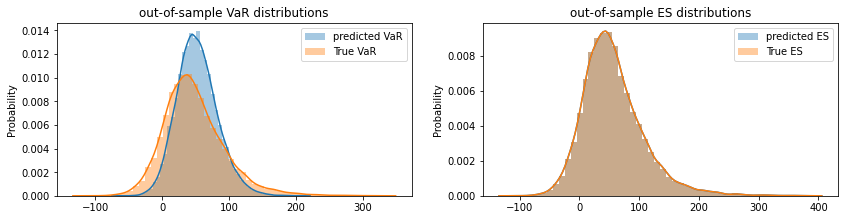

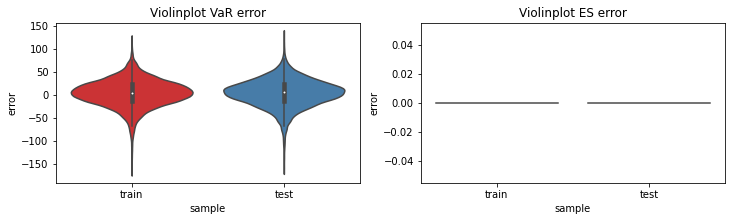

In [ ]:
plot_function(var_NN(X_train_transfomed), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test_transfomed), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:

%%time
K = 1200
RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu,
                            projection='Achlioptas'
                            )
# ['Gauss', 'Rademacher', 'Achlioptas']
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)
LR_quantile = IRLS_quantile_regression(regularization_weight=0.)

LR_quantile.fit(X_train_transfomed,Y_train)



CPU times: user 787 ms, sys: 385 ms, total: 1.17 s
Wall time: 1.18 s


NRMSE in-sample VaR:  0.5792951583862305
NRMSE out-sample VaR:  0.5981239676475525
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  25.439247131347656
RMSE out-sample VaR:  26.279634475708008
Quantile loss in-sample:  1.4997029304504395
Quantile loss out-sample:  2.182729959487915
Quantile proba in-sample:  0.07105
Quantile proba out-sample:  0.0865


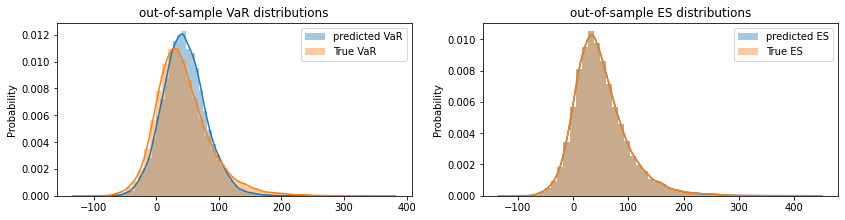

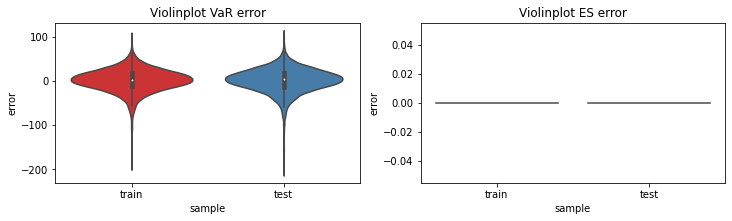

In [ ]:
plot_function(LR_quantile.predict(X_train_transfomed), true_VaR_train,
              true_ES_train, true_ES_train,
              LR_quantile.predict(X_test_transfomed), true_VaR_test,
              true_ES_test, true_ES_test)        

## RBF

In [ ]:
%%time
RBF_hlayer = RBFlayer(output_layer = 200, e = 0.1, 
                      function ='Thin plate spline'
                      )

RBF_hlayer.fit(X_train)

X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
X_test_transfomed = RBF_hlayer.transform(X_test).to(device)
LR_quantile = IRLS_quantile_regression(regularization_weight=0.)

LR_quantile.fit(X_train_transfomed,Y_train)


CPU times: user 375 ms, sys: 126 ms, total: 501 ms
Wall time: 505 ms


NRMSE in-sample VaR:  1.2937031984329224
NRMSE out-sample VaR:  1.2936570644378662
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  57.097381591796875
RMSE out-sample VaR:  57.31862258911133
Quantile loss in-sample:  13.240266799926758
Quantile loss out-sample:  13.362184524536133
Quantile proba in-sample:  0.4295
Quantile proba out-sample:  0.419


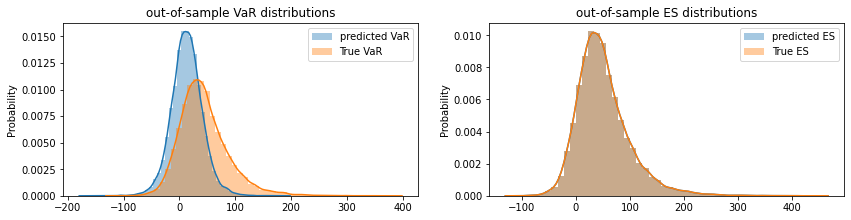

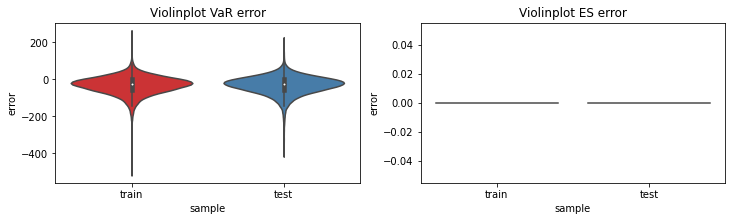

In [ ]:
plot_function(LR_quantile.predict(X_train_transfomed), true_VaR_train,
              true_ES_train, true_ES_train,
              LR_quantile.predict(X_test_transfomed), true_VaR_test,
              true_ES_test, true_ES_test)  

# 8 ES

In [63]:
def train_l2(model, x_train, y_train, learning_rate, regularization_weight,
                    epochs=max_epochs, stop_eps = 1e-8, verbose = None) :

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    while (abs(err) > 1e-8) and (i < epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = F.mse_loss(pred, y_train)
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best') 
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))

    model.load_state_dict(torch.load('best'))
    model.eval()    

In [64]:
Y_train_es = 1/eps*torch.relu(Y_train - var_NN(X_train).data) + var_NN(X_train).data
Y_train_es_true = 1/eps*torch.relu(Y_train - true_VaR_train) + true_VaR_train

In [65]:
%%time
es_NN =NN_nlayers(Layers=[dim_X,20,1], activation =F.elu).to(device)

train_l2(es_NN, X_train, Y_train_es, learning_rate=0.01, regularization_weight=0.,
         epochs = 500, verbose = 100)

[iter 0] err = 7179.761
[iter 100] err = 3763.754
[iter 200] err = 2951.908
[iter 300] err = 2886.413
[iter 400] err = 2844.301
[iter 500] err = 2811.626
Best error = 2811.922607421875
CPU times: user 887 ms, sys: 69.2 ms, total: 956 ms
Wall time: 962 ms


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.5433003306388855
NRMSE out-sample ES:  0.5395923256874084
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.295270323753357
Quantile loss out-sample:  1.292953372001648
Quantile proba in-sample:  0.02565
Quantile proba out-sample:  0.02545


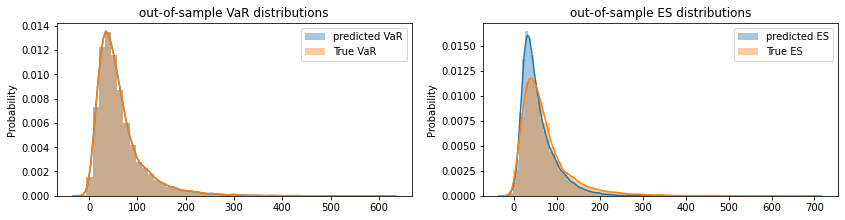

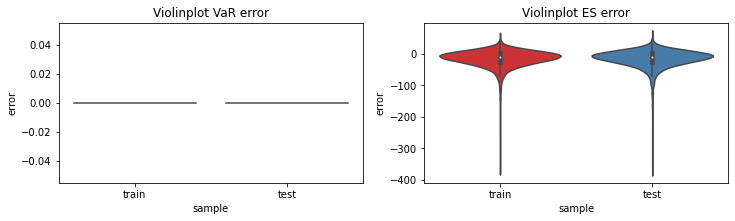

In [30]:
plot_function(true_VaR_train, true_VaR_train,
              es_NN(X_train), true_ES_train,
              true_VaR_test, true_VaR_test,
              es_NN(X_test), true_ES_test)

In [ ]:
%%time
K= 3000
LR_solution = LR_readout_cuml(regularization_weight= 0.1)

RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu,
                            projection='Achlioptas'
                            )
# ['Gauss', 'Rademacher', 'Achlioptas']
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)

LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 386 ms, sys: 265 ms, total: 651 ms
Wall time: 652 ms


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.6059387922286987
NRMSE out-sample ES:  0.6310426592826843
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.1213663816452026
Quantile loss out-sample:  1.1281135082244873
Quantile proba in-sample:  0.02515
Quantile proba out-sample:  0.0253


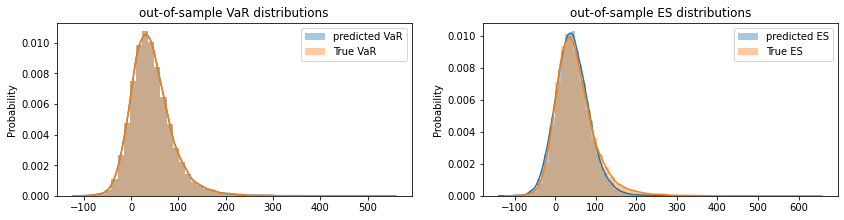

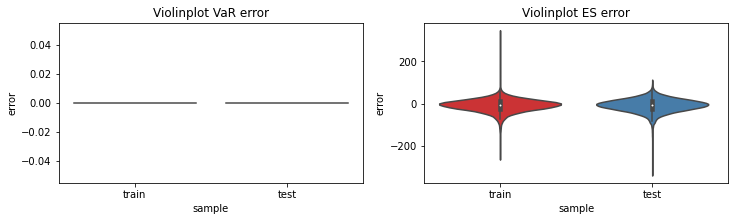

In [ ]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

In [ ]:
{'activation': 'Thin plate spline',
 'regularization_weight': 0.5,
 'shape_para': 10,
 'unit_num': 400}

In [ ]:
%%time
K = 800
RBF_hlayer = RBFlayer(output_layer = K, e = 10, 
                      function ='Thin plate spline'
                      )

RBF_hlayer.fit(X_train)

LR_solution = LR_readout_cuml(regularization_weight= 0.5)

X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
X_test_transfomed = RBF_hlayer.transform(X_test).to(device)
LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 1.03 s, sys: 165 ms, total: 1.19 s
Wall time: 1.19 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.5726780295372009
NRMSE out-sample ES:  0.5866262316703796
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.1213663816452026
Quantile loss out-sample:  1.1281135082244873
Quantile proba in-sample:  0.02515
Quantile proba out-sample:  0.0253


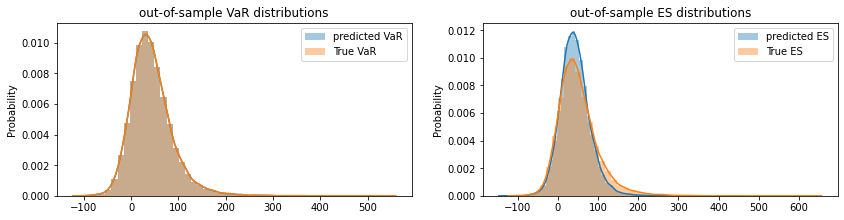

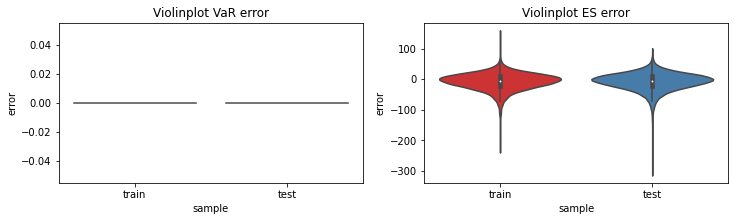

In [ ]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

## Joint approach

In [31]:
a = Y_train.std()
g1 = lambda x: x
g2 = lambda x: -torch.log(1 + torch.exp(-x/a))
g2dot = lambda x: torch.exp(-x/a)/(a + a*torch.exp(-x/a))

def joint_loss(q,e,y):
    g1_func = g1
    g2_func = g2
    g2_dot_func = g2dot
    return float(torch.mean(1/eps*torch.relu(g1_func(y) - g1_func(q)) + g1_func(q) +
                              g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.relu(y - q))))

In [32]:

def joint_train_var_es_model(model_var_es, 
                             x_train,
                             y_train, 
                             learning_rate,
                             regularization_weight, 
                             eps = 0.025, g1_func = g1, 
                             g2_func = g2, 
                             g2_dot_func = g2dot,
                             epochs=500, stop_eps = 1e-8, verbose = None) :
    optimizer = torch.optim.Adam(model_var_es.parameters(), lr=learning_rate,
                                 weight_decay=regularization_weight)
    i = 0
    best_err, err =  np.inf, np.inf

    while (abs(err) > stop_eps) and (i < epochs):       
        optimizer.zero_grad()
        pred = model_var_es(x_train)
        q = pred[:,0:1]
        e = pred[:,1:2]
        loss = torch.mean(1/eps*torch.relu(g1_func(y_train) - g1_func(q)) + g1_func(q) +
                          g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.relu(y_train - q)) )
                      
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var_es.state_dict(), 'best')

        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var_es.load_state_dict(torch.load('best'))
    model_var_es.eval()

In [33]:
%%time
var_es_NN = NN_nlayers(Layers=[dim_X,200,2], activation=F.elu).to(device)

joint_train_var_es_model(var_es_NN, X_train, Y_train,
                         learning_rate = 0.1, regularization_weight = 0.,
                         epochs=500, verbose = 100)

[iter 0] err = 932.576
[iter 100] err = 74.658
[iter 200] err = 60.598
[iter 300] err = 60.266
[iter 400] err = 57.495
[iter 500] err = 60.772
Best error = 56.38493728637695
CPU times: user 1.15 s, sys: 63.9 ms, total: 1.21 s
Wall time: 1.25 s


NRMSE in-sample VaR:  0.407166063785553
NRMSE out-sample VaR:  0.39980655908584595
NRMSE in-sample ES:  0.5064262747764587
NRMSE out-sample ES:  0.49959373474121094
RMSE in-sample VaR:  19.73689079284668
RMSE out-sample VaR:  20.026330947875977
Quantile loss in-sample:  0.9410455226898193
Quantile loss out-sample:  2.047185182571411
Quantile proba in-sample:  0.0438
Quantile proba out-sample:  0.1072


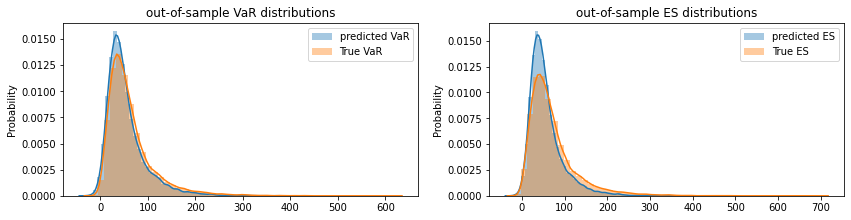

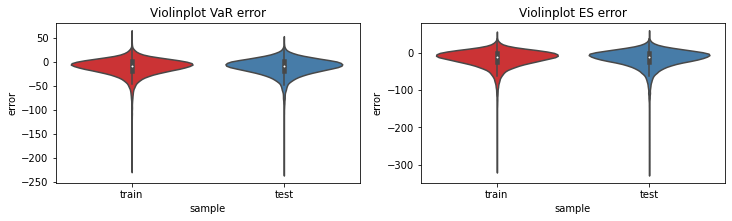

In [34]:
plot_function(var_es_NN(X_train)[:,0:1], true_VaR_train,
              var_es_NN(X_train)[:,1:2], true_ES_train,
              var_es_NN(X_test)[:,0:1], true_VaR_test,
              var_es_NN(X_test)[:,1:2], true_ES_test)

In [ ]:
%%time
K = 1200
RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu, 
                            projection = 'Gauss')
# ['Gauss', 'Rademacher', 'Achlioptas', Gauss_normalized]
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)
       
var_es_NN = NN_nlayers(Layers=[K,2], activation=F.elu).to(device)

joint_train_var_es_model(var_es_NN, X_train_transfomed, Y_train,
                         learning_rate = 0.1, regularization_weight = 0.,
                         epochs=500, verbose = 100)

[iter 0] err = 697.074
[iter 100] err = 87.887
[iter 200] err = 71.285
[iter 300] err = 76.5
[iter 400] err = 88.774
[iter 500] err = 67.622
Best error = 64.52791595458984
CPU times: user 1.01 s, sys: 68.5 ms, total: 1.08 s
Wall time: 1.11 s


NRMSE in-sample VaR:  0.5835771560668945
NRMSE out-sample VaR:  0.5994240641593933
NRMSE in-sample ES:  29.532419204711914
NRMSE out-sample ES:  30.034507751464844
RMSE in-sample VaR:  26.15623664855957
RMSE out-sample VaR:  26.546899795532227
Quantile loss in-sample:  1.626075029373169
Quantile loss out-sample:  2.0437633991241455
Quantile proba in-sample:  0.06595
Quantile proba out-sample:  0.07575


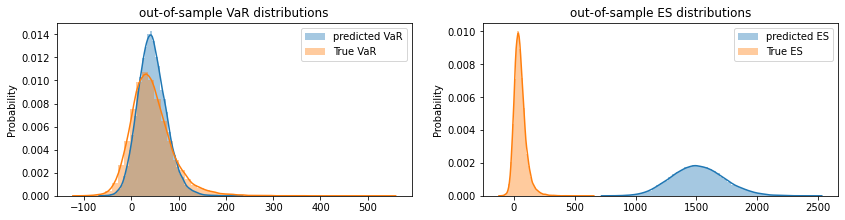

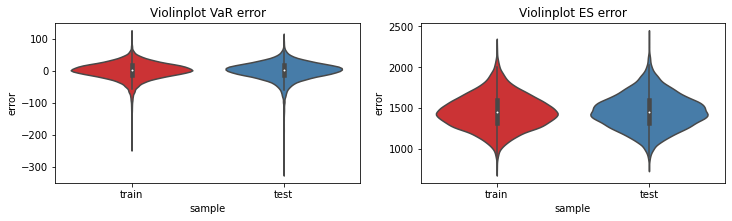

In [ ]:
plot_function(var_es_NN(X_train_transfomed)[:,0:1], true_VaR_train,
              var_es_NN(X_train_transfomed)[:,1:2], true_ES_train,
              var_es_NN(X_test_transfomed)[:,0:1], true_VaR_test,
              var_es_NN(X_test_transfomed)[:,1:2], true_ES_test)

In [ ]:
class NN_RPlayer(nn.Module):

    def __init__(self, Layers = [dim_X, 100,2], activation = torch.relu):
        super(NN_RPlayer, self).__init__()
        self.fc0 = nn.Linear(Layers[0],Layers[1])
        self.fc1 = nn.Linear(Layers[1],Layers[2])
        torch.nn.init.normal_(self.fc0.weight)
        torch.nn.init.normal_(self.fc0.bias)
        self.fc0.weight.requires_grad = False
        self.fc0.bias.requires_grad = False
        self.activation = activation

    def forward(self, x):
        x = x.to(device)
        x = self.activation(self.fc0(x))
              
        return self.fc1(x)

In [ ]:
%%time
var_es_NN = NN_RPlayer([dim_X,200,2], activation=F.elu).to(device)


CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 1.71 ms


In [ ]:
%%time
var_es_NN = NN_RPlayer([dim_X,2000,2], activation=F.elu).to(device)

joint_train_var_es_model(var_es_NN, X_train, Y_train,
                         learning_rate = 0.1, regularization_weight = 0.,
                         epochs=500, verbose = 100)

[iter 0] err = 694.62
[iter 100] err = 88.556
[iter 200] err = 64.699
[iter 300] err = 1172.619
[iter 400] err = 67.469
[iter 500] err = 61.699
Best error = 57.52879333496094
CPU times: user 2.2 s, sys: 1.08 s, total: 3.28 s
Wall time: 3.39 s


In [ ]:
torch.nn.parameter.Parameter(torch.Tensor(1, 20))

Parameter containing:
tensor([[1.5477e+05, 1.4013e-45, 7.0065e-44, 6.7262e-44, 6.3058e-44, 6.7262e-44,
         7.9874e-44, 6.3058e-44, 7.0065e-44, 6.8664e-44, 1.1771e-43, 6.7262e-44,
         7.2868e-44, 8.1275e-44, 6.7262e-44, 7.1466e-44, 8.1275e-44, 6.8664e-44,
         7.2868e-44, 6.4460e-44]], requires_grad=True)

NRMSE in-sample VaR:  0.541034460067749
NRMSE out-sample VaR:  0.5583215951919556
NRMSE in-sample ES:  50.4303092956543
NRMSE out-sample ES:  51.16260528564453
RMSE in-sample VaR:  24.24945068359375
RMSE out-sample VaR:  24.726579666137695
Quantile loss in-sample:  1.3442416191101074
Quantile loss out-sample:  1.8685132265090942
Quantile proba in-sample:  0.05265
Quantile proba out-sample:  0.0609


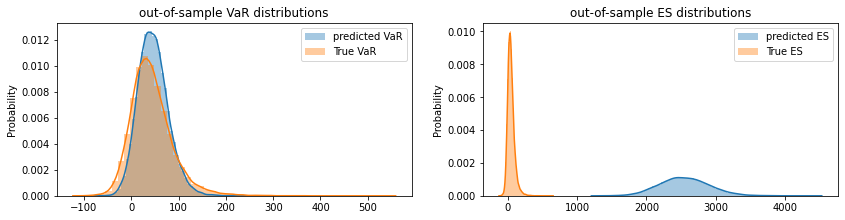

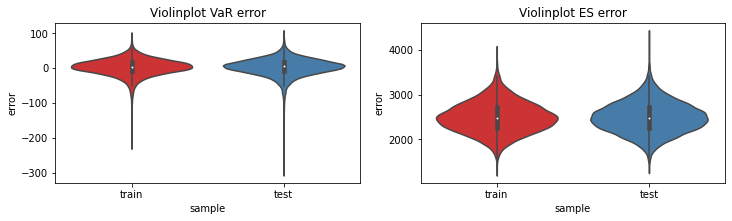

In [ ]:
plot_function(var_es_NN(X_train)[:,0:1], true_VaR_train,
              var_es_NN(X_train)[:,1:2], true_ES_train,
              var_es_NN(X_test)[:,0:1], true_VaR_test,
              var_es_NN(X_test)[:,1:2], true_ES_test)

# 9 Benchmark

## VaR

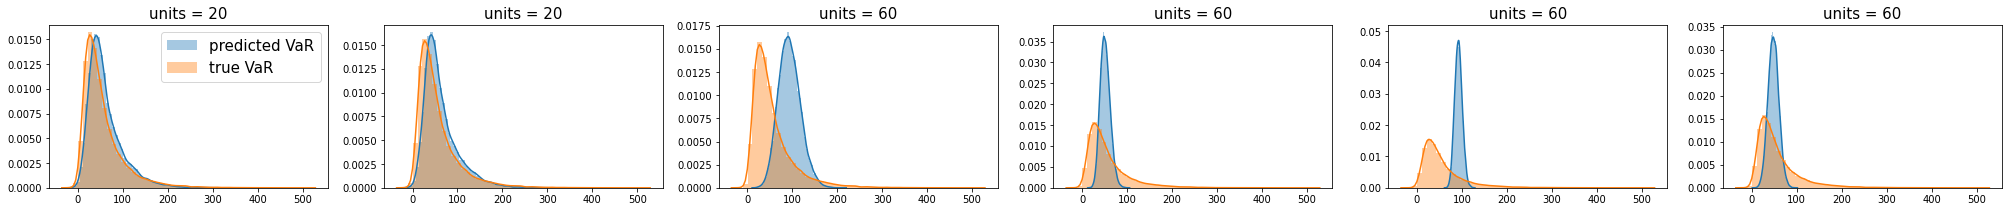

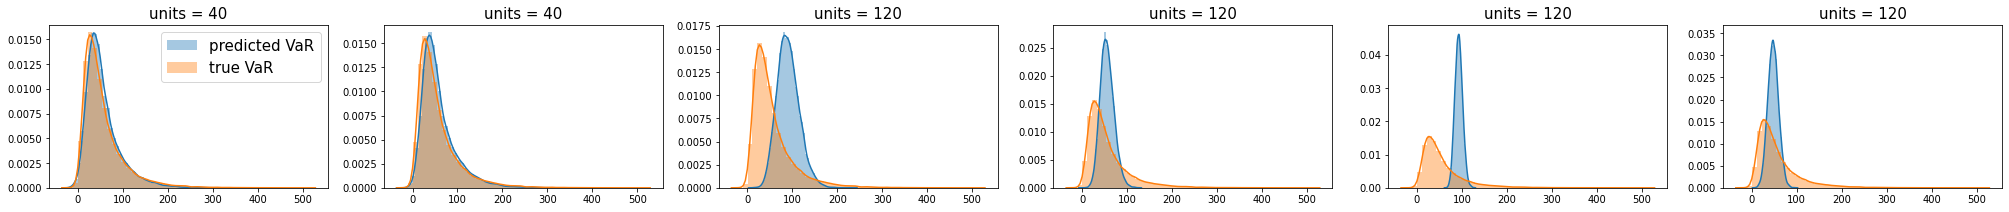

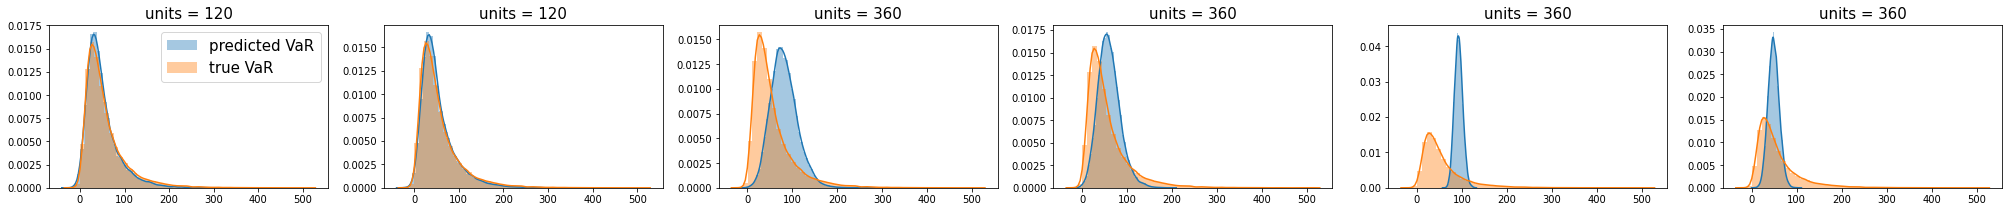

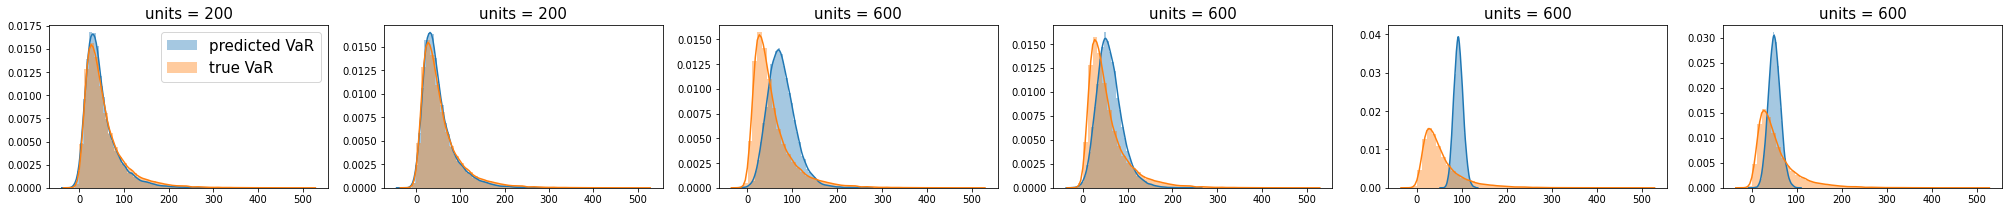

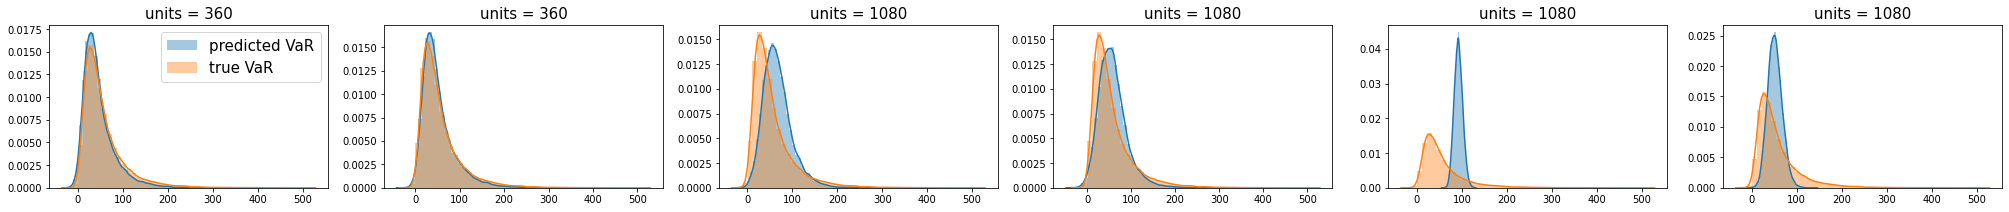

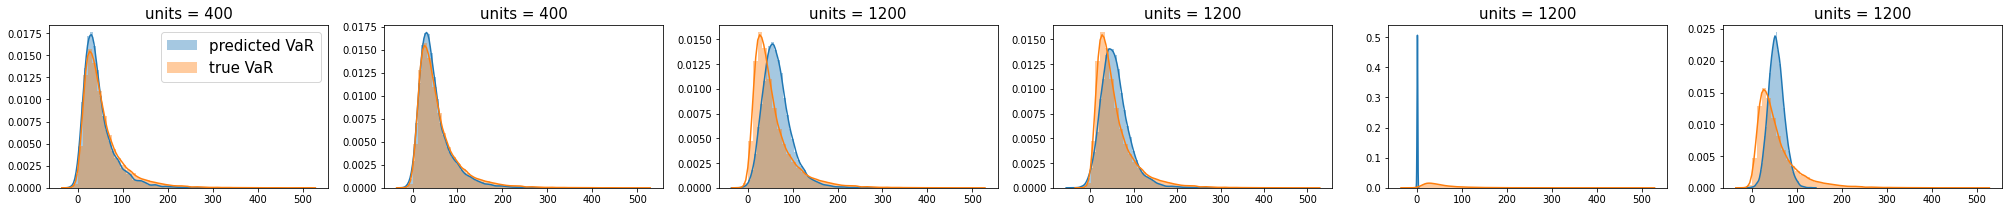

In [66]:
hunits_list = [20,40,120,200,360,400]
NRMSE_Var_NN_list = []
RMSE_Var_NN_list = []
Qloss_NN_list = []
time_NN_list = []

NRMSE_Var_NN_Huber_list = []
RMSE_Var_NN_Huber_list = []
Qloss_NN_Huber_list = []
time_NN_Huber_list = []

NRMSE_Var_ELM_Adam_list = []
RMSE_Var_ELM_Adam_list = []
Qloss_ELM_Adam_list = []
time_ELM_Adam_list = []

NRMSE_Var_ELM_IR_list = []
RMSE_Var_ELM_IR_list = []
Qloss_ELM_IR_list = []
time_ELM_IR_list = []

NRMSE_Var_RBF_Adam_list = []
RMSE_Var_RBF_Adam_list = []
Qloss_RBF_Adam_list = []
time_RBF_Adam_list = []

NRMSE_Var_RBF_IR_list = []
RMSE_Var_RBF_IR_list = []
Qloss_RBF_IR_list = []
time_RBF_IR_list = []


for units in hunits_list:
    p1 = time.time()
    var_NN = NN_nlayers(Layers=[dim_X,units,1], activation =F.elu).to(device)

    train_var_RUbased_v2(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                    epochs = 500, stop_eps = 1e-8, verbose = None, lr = 0.1)
    time_NN_list.append(time.time() - p1)

    NRMSE_Var_NN_list.append(NRMSE(var_NN(X_test), true_VaR_test))
    RMSE_Var_NN_list.append(RMSE(var_NN(X_test), true_VaR_test))
    Qloss_NN_list.append(qloss(var_NN(X_test), Y_test))
    var_NN_predicted = var_NN(X_test).cpu().data
    ####################
    p1 = time.time()
    var_NN = NN_nlayers(Layers=[dim_X,units,1], activation =F.elu).to(device)

    train_var_huberloss(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                    epochs = 500, stop_eps = 1e-8, verbose = None, lr = 0.1)
    time_NN_Huber_list.append(time.time() - p1)

    NRMSE_Var_NN_Huber_list.append(NRMSE(var_NN(X_test), true_VaR_test))
    RMSE_Var_NN_Huber_list.append(RMSE(var_NN(X_test), true_VaR_test))
    Qloss_NN_Huber_list.append(qloss(var_NN(X_test), Y_test))
    var_NN_Huber_predicted = var_NN(X_test).cpu().data

    ####################
    p1 = time.time()
    RP_layer = Randomprojection(Layers=[dim_X,units*3], random_state= None, activation= F.elu, 
                            projection = 'Gauss')

    X_train_transfomed = RP_layer.fit_transform(X_train)
    X_test_transfomed = RP_layer.fit_transform(X_test)
       
    var_NN = NN_nlayers(Layers=[units*3,1], activation =F.relu).to(device)

    train_var_RUbased_v2(var_NN, X_train_var= X_train_transfomed,y_train= Y_train,
                     eps = eps, epochs = 500, stop_eps = 1e-8, verbose = None, lr = 0.1)
    time_ELM_Adam_list.append(time.time() - p1)

    NRMSE_Var_ELM_Adam_list.append(NRMSE(var_NN(X_test_transfomed), true_VaR_test))
    RMSE_Var_ELM_Adam_list.append(RMSE(var_NN(X_test_transfomed), true_VaR_test))
    Qloss_ELM_Adam_list.append(qloss(var_NN(X_test_transfomed), Y_test))
    var_ELM_Adam_predicted = var_NN(X_test_transfomed).cpu().data

    #####################
    p1 = time.time()
    RP_layer = Randomprojection(Layers=[dim_X,units*3], random_state= None, activation= F.elu,
                                projection='Achlioptas'
                                )

    X_train_transfomed = RP_layer.fit_transform(X_train)
    X_test_transfomed = RP_layer.fit_transform(X_test)
    LR_quantile = IRLS_quantile_regression(regularization_weight=0.)

    LR_quantile.fit(X_train_transfomed,Y_train)
    
    time_ELM_IR_list.append(time.time() - p1)

    NRMSE_Var_ELM_IR_list.append(NRMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    RMSE_Var_ELM_IR_list.append(RMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    Qloss_ELM_IR_list.append(qloss(LR_quantile.predict(X_test_transfomed), Y_test))
    var_ELM_IR_predicted = LR_quantile.predict(X_test_transfomed).cpu().data

    #####################
    p1 = time.time()

    RBF_hlayer = RBFlayer(output_layer = units*3, e = 1, 
                          function ='Multiquadric'
                          )
    RBF_hlayer.fit(X_train)

    X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
    X_test_transfomed = RBF_hlayer.transform(X_test).to(device)

    var_NN = NN_nlayers(Layers=[units*3,1], activation = torch.nn.Identity).to(device)

    train_var_RUbased_v2(var_NN, X_train_var= X_train_transfomed,y_train= Y_train, 
                         regularization_weight = 1., epochs = 500, verbose = None, lr = 0.1)
    
    time_RBF_Adam_list.append(time.time() - p1)

    NRMSE_Var_RBF_Adam_list.append(NRMSE(var_NN(X_test_transfomed), true_VaR_test))
    RMSE_Var_RBF_Adam_list.append(RMSE(var_NN(X_test_transfomed), true_VaR_test))
    Qloss_RBF_Adam_list.append(qloss(var_NN(X_test_transfomed), Y_test))
    var_RBF_Adam_predicted = var_NN(X_test_transfomed).cpu().data

    ######
    p1 = time.time()

    RBF_hlayer = RBFlayer(output_layer = units*3, e = 1, 
                          function ='Multiquadric'
                          )
    RBF_hlayer.fit(X_train)

    X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
    X_test_transfomed = RBF_hlayer.transform(X_test).to(device)

    LR_quantile = IRLS_quantile_regression(regularization_weight=1.)

    LR_quantile.fit(X_train_transfomed,Y_train)
    
    time_RBF_IR_list.append(time.time() - p1)

    NRMSE_Var_RBF_IR_list.append(NRMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    RMSE_Var_RBF_IR_list.append(RMSE(LR_quantile.predict(X_test_transfomed), true_VaR_test))
    Qloss_RBF_IR_list.append(qloss(LR_quantile.predict(X_test_transfomed), Y_test))
    var_RBF_IR_predicted = LR_quantile.predict(X_test_transfomed).cpu().data

    plt.figure(figsize=(35,3))
    plt.subplot(161)
    g = sns.distplot(var_NN_predicted, label='predicted VaR')
    g = sns.distplot(true_VaR_test.cpu().data, label='true VaR')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.subplot(162)
    g = sns.distplot(var_NN_Huber_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    plt.subplot(163)
    g = sns.distplot(var_ELM_Adam_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.subplot(164)
    g = sns.distplot(var_ELM_IR_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.subplot(165)
    g = sns.distplot(var_RBF_Adam_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.subplot(166)
    g = sns.distplot(var_RBF_IR_predicted)
    g = sns.distplot(true_VaR_test.cpu().data)
    g = plt.title("units = "+str(units*3), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    plt.show()
    print('========================')
    del var_NN, LR_quantile, X_train_transfomed, X_test_transfomed, RBF_hlayer, RP_layer
    torch.cuda.empty_cache()
    gc.collect()

In [67]:
result = pd.DataFrame()
result['Model'] = [i for i in ['NN', 'NN_Huber','ELM_Adam(x3)', 'ELM_IRLS(x3)', 'RBF_Adam(x3)', 'RBF_IRLS(x3)'] for _ in range(6)]
result['units'] = [20,40,120,200,360,400]*6
result['NRMSE'] = NRMSE_Var_NN_list + NRMSE_Var_NN_Huber_list+ NRMSE_Var_ELM_Adam_list + NRMSE_Var_ELM_IR_list + NRMSE_Var_RBF_Adam_list + NRMSE_Var_RBF_IR_list
result['RMSE'] = RMSE_Var_NN_list + RMSE_Var_NN_Huber_list + RMSE_Var_ELM_Adam_list + RMSE_Var_ELM_IR_list + RMSE_Var_RBF_Adam_list + RMSE_Var_RBF_IR_list
result['Qloss'] = Qloss_NN_list + Qloss_NN_Huber_list + Qloss_ELM_Adam_list + Qloss_ELM_IR_list + Qloss_RBF_Adam_list + Qloss_RBF_IR_list
result['time'] = time_NN_list + time_NN_Huber_list + time_ELM_Adam_list + time_ELM_IR_list + time_RBF_Adam_list + time_RBF_IR_list


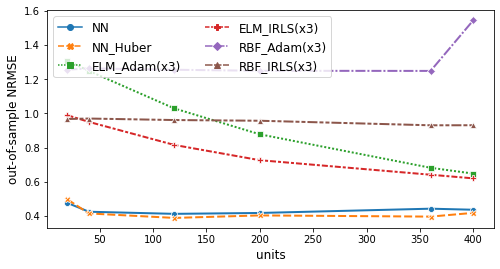

In [68]:
plt.figure(figsize=(8,4))
g = sns.lineplot(data = result, x = 'units', y = 'NRMSE', style = 'Model', hue = 'Model', linewidth = 2, markers=True)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("out-of-sample NRMSE", fontsize = 12)
g = plt.xlabel("units", fontsize = 12)

g = plt.legend(fontsize = 12,loc='upper left', ncol=2,handles=handles[1:], labels=labels[1:])

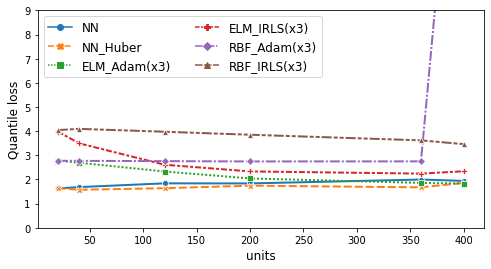

In [69]:
plt.figure(figsize=(8,4))
g = sns.lineplot(data = result, x = 'units', y = 'Qloss', style = 'Model', hue = 'Model', linewidth = 2, markers=True)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("Quantile loss", fontsize = 12)
g = plt.xlabel("units", fontsize = 12)
plt.ylim([0,9])
g = plt.legend(fontsize = 12,loc='upper left', ncol=2,handles=handles[1:], labels=labels[1:])

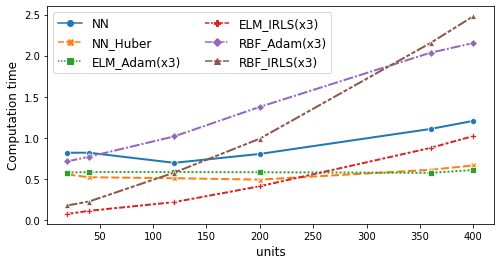

In [70]:
plt.figure(figsize=(8,4))
g = sns.lineplot(data = result, x = 'units', y = 'time', style = 'Model', hue = 'Model', linewidth = 2, markers=True)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("Computation time", fontsize = 12)
g = plt.xlabel("units", fontsize = 12)
g = plt.legend(fontsize = 12,loc='upper left', ncol=2,handles=handles[1:], labels=labels[1:])

In [71]:
result

,Model,units,NRMSE,RMSE,Qloss,time
0,NN,20,0.475588,22.015484,1.628505,0.817374
1,NN,40,0.424277,19.640215,1.685202,0.817714
2,NN,120,0.411879,19.066338,1.839894,0.694479
3,NN,200,0.417093,19.307659,1.836636,0.802759
4,NN,360,0.442102,20.465355,1.997604,1.107150
5,NN,400,0.435931,20.179708,1.940596,1.205460
6,NN_Huber,20,0.496158,22.967705,1.642586,0.553612
7,NN_Huber,40,0.414306,19.178684,1.574457,0.518677
8,NN_Huber,120,0.388105,17.965809,1.639559,0.507223
9,NN_Huber,200,0.402729,18.642742,1.744320,0.490026


## ES

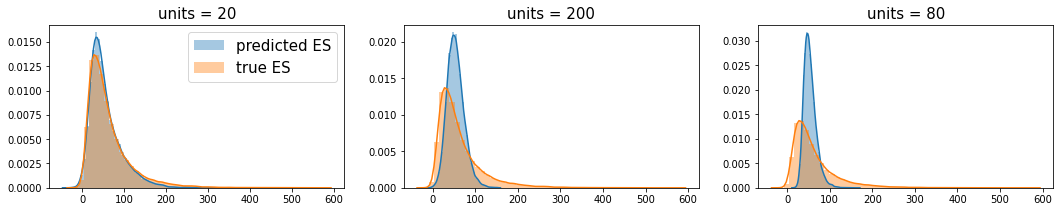

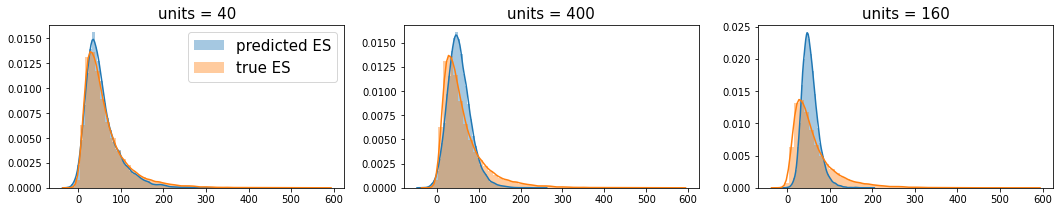

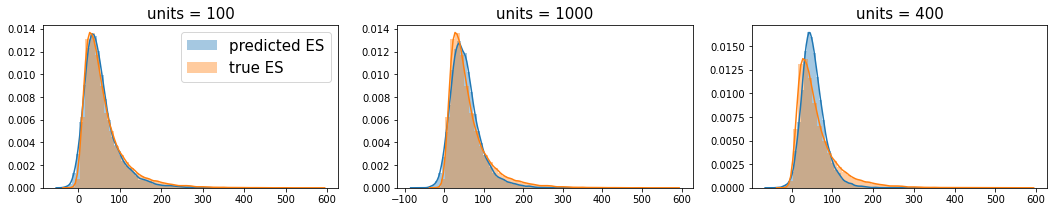

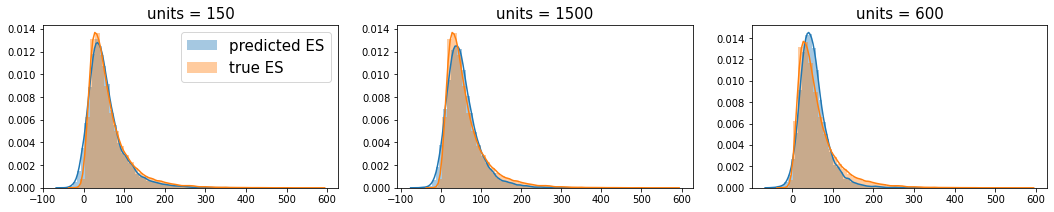

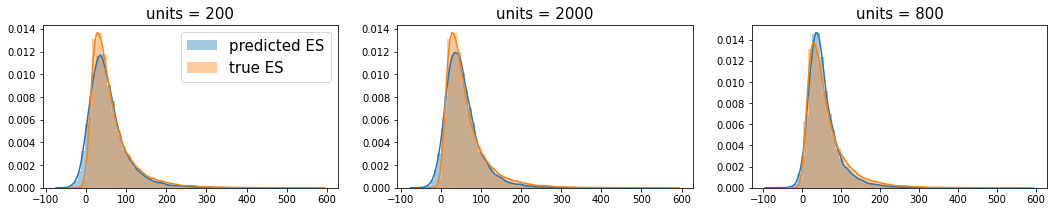

In [72]:
hunits_list = [20,40,100,150,200]
NRMSE_ES_NN_list = []
RMSE_ES_NN_list = []
time_ES_NN_list = []

NRMSE_ES_ELM_list = []
RMSE_ES_ELM_list = []
time_ES_ELM_list = []

NRMSE_ES_RBF_list = []
RMSE_ES_RBF_list = []
time_ES_RBF_list = []

for units in hunits_list:

    p1 = time.time()
    es_NN =NN_nlayers(Layers=[dim_X,units,1], activation =F.elu).to(device)

    train_l2(es_NN, X_train, Y_train_es, learning_rate=0.01, regularization_weight=0.,
            epochs = 500, verbose = None)
    time_ES_NN_list.append(time.time() - p1)

    NRMSE_ES_NN_list.append(NRMSE(es_NN(X_test), true_ES_test))
    RMSE_ES_NN_list.append(RMSE(es_NN(X_test), true_ES_test))
    es_NN_predicted = es_NN(X_test).cpu().data
    ####################
    p1 = time.time()
    
    LR_solution = LR_readout_cuml(regularization_weight= 0.1)

    RP_layer = Randomprojection(Layers=[dim_X,units*10], random_state= None, activation= F.elu,
                            projection='Achlioptas'
                            )
    # ['Gauss', 'Rademacher', 'Achlioptas']
    X_train_transfomed = RP_layer.fit_transform(X_train)
    X_test_transfomed = RP_layer.fit_transform(X_test)

    LR_solution.fit(X_train_transfomed, Y_train_es)
    time_ES_ELM_list.append(time.time() - p1)
    NRMSE_ES_ELM_list.append(NRMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    RMSE_ES_ELM_list.append(RMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    es_ELM_predicted = LR_solution.predict(X_test_transfomed).cpu().data

    ####################
    p1 = time.time()
    RBF_hlayer = RBFlayer(output_layer = units*4, e = 10, 
                          function ='Thin plate spline'
                          )
    RBF_hlayer.fit(X_train)

    LR_solution = LR_readout_cuml(regularization_weight= 0.5)

    X_train_transfomed = RBF_hlayer.transform(X_train).to(device)
    X_test_transfomed = RBF_hlayer.transform(X_test).to(device)
    LR_solution.fit(X_train_transfomed, Y_train_es)
    time_ES_RBF_list.append(time.time() - p1)
    NRMSE_ES_RBF_list.append(NRMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    RMSE_ES_RBF_list.append(RMSE(LR_solution.predict(X_test_transfomed), true_ES_test))
    es_RBF_predicted = LR_solution.predict(X_test_transfomed).cpu().data

    plt.figure(figsize=(18,3))
    plt.subplot(131)
    g = sns.distplot(es_NN_predicted, label='predicted ES')
    g = sns.distplot(true_ES_test.cpu().data, label='true ES')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.subplot(132)
    g = sns.distplot(es_ELM_predicted)
    g = sns.distplot(true_ES_test.cpu().data)
    g = plt.title("units = "+str(units*10), fontsize=15)
    g = plt.xlabel("")
    plt.subplot(133)
    g = sns.distplot(es_RBF_predicted)
    g = sns.distplot(true_ES_test.cpu().data)
    g = plt.title("units = "+str(units*4), fontsize=15)
    g = plt.xlabel("")
    #g = plt.legend(fontsize = 15)
    
    plt.show()
    print('========================')
    del es_NN, LR_solution, X_train_transfomed, X_test_transfomed, RBF_hlayer, RP_layer
    torch.cuda.empty_cache()
    gc.collect()

In [73]:
result_ES = pd.DataFrame()
result_ES['Model'] = [i for i in ['NN', 'ELM(x10)', 'RBF(x4)'] for _ in range(5)]
result_ES['units'] = [20,40,100,150,200]*3
result_ES['NRMSE'] = NRMSE_ES_NN_list + NRMSE_ES_ELM_list + NRMSE_ES_RBF_list
result_ES['RMSE'] = RMSE_ES_NN_list + RMSE_ES_ELM_list + RMSE_ES_RBF_list
result_ES['time'] = time_ES_NN_list + time_ES_ELM_list + time_ES_RBF_list


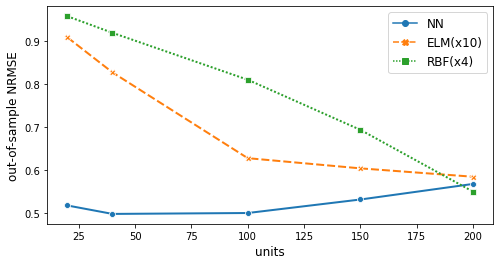

In [74]:
plt.figure(figsize=(8,4))
g = sns.lineplot(data = result_ES, x = 'units', y = 'NRMSE', style = 'Model', hue = 'Model', linewidth = 2, markers=True)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("out-of-sample NRMSE", fontsize = 12)
g = plt.xlabel("units", fontsize = 12)

g = plt.legend(fontsize = 12,loc='upper right', ncol=1,handles=handles[1:], labels=labels[1:])

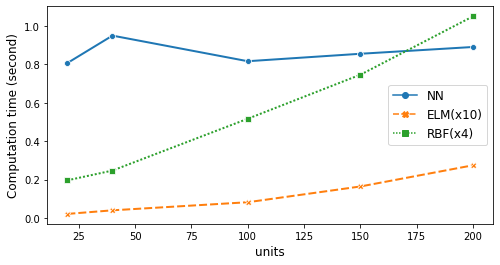

In [75]:
plt.figure(figsize=(8,4))
g = sns.lineplot(data = result_ES, x = 'units', y = 'time', style = 'Model', hue = 'Model', linewidth = 2, markers=True)
handles, labels = g.get_legend_handles_labels()
g = plt.ylabel("Computation time (second)", fontsize = 12)
g = plt.xlabel("units", fontsize = 12)

g = plt.legend(fontsize = 12,ncol=1,handles=handles[1:], labels=labels[1:])

In [76]:
result_ES

,Model,units,NRMSE,RMSE,time
0,NN,20,0.517862,27.040907,0.806631
1,NN,40,0.498278,26.018265,0.949445
2,NN,100,0.500370,26.127544,0.816127
3,NN,150,0.531733,27.765203,0.854930
4,NN,200,0.567894,29.653389,0.890318
5,ELM(x10),20,0.907959,47.410366,0.020885
6,ELM(x10),40,0.826654,43.164883,0.039618
7,ELM(x10),100,0.627634,32.772808,0.081767
8,ELM(x10),150,0.603969,31.537083,0.163867
9,ELM(x10),200,0.584526,30.521866,0.274325


In [77]:
torch.cuda.empty_cache()
gc.collect()

36093

## Joint approach

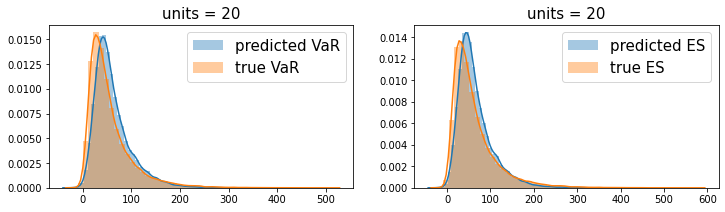

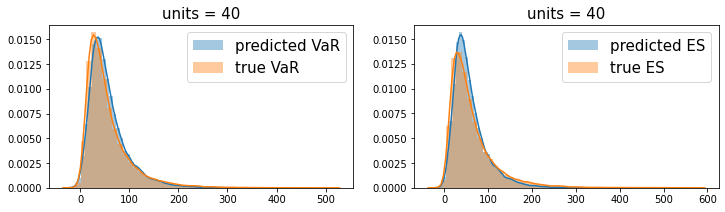

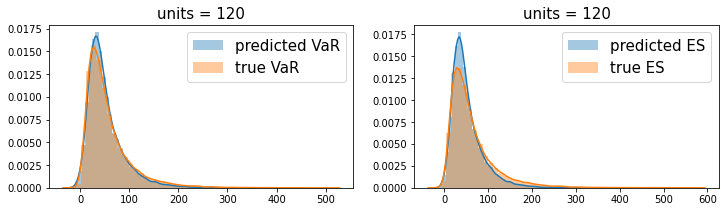

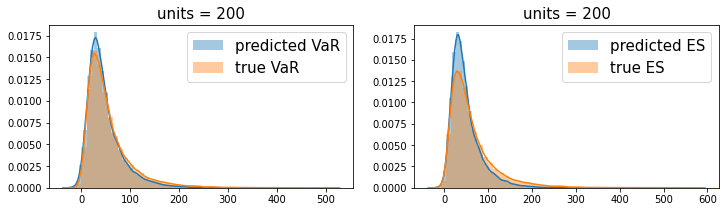

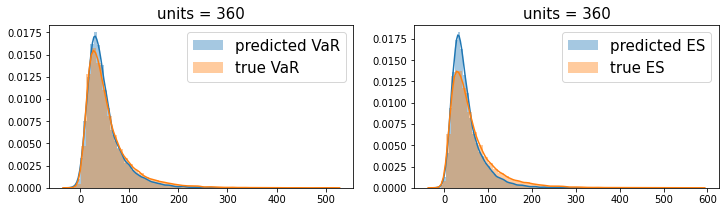

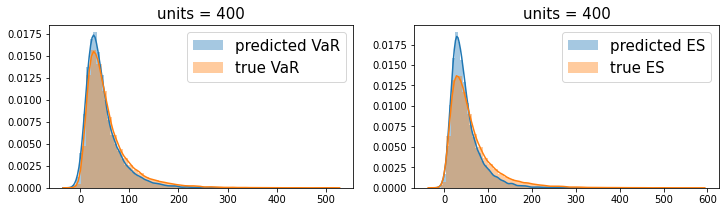

In [91]:
hunits_list = [20,40,120,200,360,400]
#NRMSE_Var_RU_list = []
#RMSE_Var_RU_list = []
#NRMSE_ES_RU_list = []
#RMSE_ES_RU_list = []
#time_RU_list = []

NRMSE_Var_joint_list = []
RMSE_Var_joint_list = []
NRMSE_ES_joint_list = []
RMSE_ES_joint_list = []
time_joint_list = []

for units in hunits_list:
    p1 = time.time()
    var_es_NN = NN_nlayers(Layers=[dim_X,units,2], activation=F.elu).to(device)

    joint_train_var_es_model(var_es_NN, X_train, Y_train,
                            learning_rate = 0.1, regularization_weight = 0.,
                            epochs=500, verbose = None)
    time_joint_list.append(time.time() - p1)

    var_predicted = var_es_NN(X_test)[:,0:1]
    es_predicted = var_es_NN(X_test)[:,1:2]

    NRMSE_Var_joint_list.append(NRMSE(var_predicted, true_VaR_test))
    RMSE_Var_joint_list.append(RMSE(var_predicted, true_VaR_test))
    
    NRMSE_ES_joint_list.append(NRMSE(es_predicted, true_ES_test))
    RMSE_ES_joint_list.append(RMSE(es_predicted, true_ES_test))

    plt.figure(figsize=(12,3))
    plt.subplot(121)
    g = sns.distplot(var_predicted.cpu().data, label='predicted VaR')
    g = sns.distplot(true_VaR_test.cpu().data, label='true VaR')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.subplot(122)
    g = sns.distplot(es_predicted.cpu().data, label='predicted ES')
    g = sns.distplot(true_ES_test.cpu().data, label='true ES')
    g = plt.title("units = "+str(units), fontsize=15)
    g = plt.xlabel("")
    g = plt.legend(fontsize = 15)
    plt.show()
    print('========================')
    del var_es_NN
    torch.cuda.empty_cache()
    gc.collect()

In [92]:
result_joint = pd.DataFrame()
result_joint['NRMSE_VaR'] = NRMSE_Var_joint_list
result_joint['RMSE_VaR'] = RMSE_Var_joint_list
result_joint['NRMSE_ES'] = NRMSE_ES_joint_list
result_joint['RMSE_ES'] = RMSE_ES_joint_list
result_joint['time'] = time_joint_list
result_joint['units'] = [20,40,120,200,360,400]

In [93]:
result_joint

,NRMSE_VaR,RMSE_VaR,NRMSE_ES,RMSE_ES,time,units
0,0.485920,22.493742,0.492419,25.712339,1.245217,20
1,0.416518,19.281044,0.461343,24.089663,1.210420,40
2,0.407396,18.858814,0.502069,26.216255,1.324502,120
3,0.424042,19.629379,0.524161,27.369799,1.149679,200
4,0.400790,18.552984,0.503083,26.269186,1.446102,360
5,0.438873,20.315882,0.538555,28.121420,1.513366,400


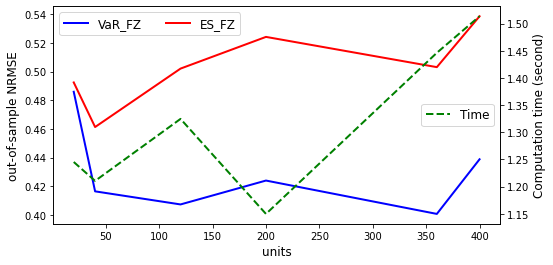

In [94]:
plt.figure(figsize=(8,4))
sns.lineplot(data=result_joint, x = 'units', y = 'NRMSE_VaR', linewidth = 2, label = 'VaR_FZ', color = 'b')
sns.lineplot(data=result_joint, x = 'units', y = 'NRMSE_ES', linewidth = 2, label = 'ES_FZ', color = 'red')
#sns.lineplot(x = result['units'][result['Model'] == 'NN'], y = result['NRMSE'][result['Model'] == 'NN'], label = 'VaR_RU', 
#             color = 'orange', linestyle='--')
#sns.lineplot(x = result_ES['units'][result_ES['Model'] == 'ELM(x10)'], y = result_ES['NRMSE'][result_ES['Model'] == 'ELM(x10)'], label = 'ES_RU')

plt.ylabel("out-of-sample NRMSE", fontsize = 12)
plt.xlabel("units", fontsize = 12)
plt.legend(fontsize = 12,loc='upper left', ncol=2)
ax2 = plt.twinx()
g = sns.lineplot(data=result_joint, x = 'units', y = 'time', linewidth = 2, markers=True,ax=ax2, color = 'g', label = 'Time', linestyle = '-')
g.lines[0].set_linestyle("--")
plt.ylabel("Computation time (second)", fontsize = 12)
plt.legend(fontsize = 12,loc='center right', ncol=2)
plt.show()